<a href="https://colab.research.google.com/github/lagom-QB/M12/blob/master/Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework №2

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the machine translation translation task.

Please, select the language you prefer from the [OPUS webpage](http://opus.nlpl.eu/News-Commentary.php). You need the plain txt format which is availabe in the bottom of the page (last table, lower-left triangle (`Bottom-left triangle: download plain text files (MOSES/GIZA++)`)).


Please, select the language pairs with English (so it might be `en-ar` or `en-ru` etc.)

English will be the target language.

__Please, avoid the language pairs with small corpus (e.g. the en-ja). The link should be green if there is rather big dataset.__


After you downloaded the file, unzip in the working directory (`unzip <FILE_NAME>` in the console. Use `! unzip <FILE NAME>` in Colab).

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* Pre-trained word embeddings for the source and target languages

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
# Uncomment the following cell on Colab
! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/homeworks/homework02/utils.py -nc
! wget https://raw.githubusercontent.com/lagom-QB/M12/master/Week%2002/attention_network.py -nc
! wget https://raw.githubusercontent.com/neychev/harbour_dlia2020/master/homeworks/homework02/my_network.py -nc

File ‘utils.py’ already there; not retrieving.

File ‘attention_network.py’ already there; not retrieving.

File ‘my_network.py’ already there; not retrieving.



In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (8, 6), 'font.size': 8})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

Change the filenames for your language pairs.

In [ ]:
# Here comes the download for the en-fr language pair

! python -m spacy download en
! python -m spacy download fr

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')


The cell below combines the pairs into one dataset. `MAX_LENGTH` const can be adjusted, but avoid the phrases longer than 100 tokens.

In [ ]:
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Load the model

spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
ROOT = './'
Multi30k.download(ROOT)

'./multi30k/'

In [ ]:
SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(   
                                                        path       = ROOT,  
                                                        exts       = ['.fr', '.en'],   
                                                        fields     = [('src', SRC), 
                                                                      ('trg',TRG)],
                                                        test       = '/content/multi30k/test2016',
                                                        train      =  '/content/multi30k/train',
                                                        validation =  '/content/multi30k/val'
                                                    )
# Split the data

In [ ]:
train_data.examples[0].src[::-1], train_data.examples[0].trg

(['deux',
  'jeunes',
  'hommes',
  'blancs',
  'sont',
  'dehors',
  'près',
  'de',
  'buissons',
  '.'],
 ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.'])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


You can adjust the `MIN_FREQ` as well (stick to ~10k unique tokens in each language).

In [ ]:
MIN_FREQ_SRC = 2
MIN_FREQ_TRG = 2

In [ ]:
SRC.build_vocab(train_data, 
                min_freq = MIN_FREQ_SRC)
TRG.build_vocab(train_data, 
                min_freq = MIN_FREQ_TRG)

# Create vocabulary associated with each language

In [ ]:
print(f"Unique tokens in source vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (EN) vocabulary: {len(TRG.vocab)}")

Unique tokens in source vocabulary: 6462
Unique tokens in target (EN) vocabulary: 5893


Here are tokens from original corpus:

In [ ]:
'Source corpus sample: %s'%[*SRC.vocab.itos[::10]] ,'Target(EN) corpus sample: %s' %[*TRG.vocab.itos[::10]]

('Source corpus sample: [\'<unk>\', \'dans\', "l\'", \'au\', \'chien\', \'pour\', \'qui\', \'près\', \'air\', \'marche\', \'regardent\', \'table\', \'filles\', \'chiens\', \'leurs\', \'sac\', \'terrain\', \'gris\', \'couple\', \'grande\', \'prend\', \'noirs\', \'âgé\', \'lit\', \'arbres\', \'travaille\', \'tenues\', \'camion\', \'livre\', \'bleus\', \'fenêtre\', \'lac\', \'bonnet\', \'zone\', \'chariot\', \'briques\', \'quai\', \'fontaine\', \'photos\', \'graffitis\', \'utilisant\', \'fruits\', \'attendant\', \'cour\', \'proximité\', \'posant\', \'montagnes\', \'sautent\', \'yeux\', \'concert\', \'coin\', \'comme\', \'noël\', \'sans\', \'cigarette\', \'ballons\', \'artiste\', \'rocheuse\', \'roulant\', \'martiaux\', \'parler\', \'masque\', \'longues\', \'lieu\', \'manches\', \'photographe\', \'discutent\', \'tour\', \'laisse\', \'boue\', \'boisson\', \'cravate\', \'joueuse\', \'coureur\', \'électrique\', \' \', \'paroi\', \'salon\', \'sandales\', \'ruelle\', \'peut\', \'chat\', \'accro

In [ ]:
SRC.vocab.itos[::222], TRG.vocab.itos[::222]

(['<unk>',
  'équipe',
  'instruments',
  'tirant',
  'tissu',
  'attaché',
  'sortant',
  'flûte',
  'dessine',
  'meubles',
  'douche',
  'murale',
  'mouillée',
  'informations',
  'bob',
  'plutôt',
  'chaton',
  'mule',
  'éparpillés',
  'couteaux',
  'lancés',
  'quais',
  'aborde',
  'burqa',
  'dressent',
  'garniture',
  'matador',
  'pratiquants',
  'soignée',
  'émerveillée'],
 ['<unk>',
  'covered',
  'dock',
  'females',
  'lab',
  'boats',
  'medical',
  'flowered',
  'drive',
  'contraption',
  'tags',
  'bush',
  'bikinis',
  'tips',
  'memorial',
  'casts',
  'pancake',
  'unpaved',
  'ds',
  'monks',
  'sticker',
  'bicycler',
  'depicted',
  'hide',
  'navigate',
  'sax',
  'tilts'])

And here is example from train dataset:

In [ ]:
vars(train_data.examples[2222])

{'src': ['.', 'terrasse', 'sa', 'sur', 'flâne', 'famille', 'une'],
 'trg': ['a', 'family', 'is', 'lounging', 'on', 'their', 'porch', '.']}

Let's check the length distributions:

Length distribution in Train data


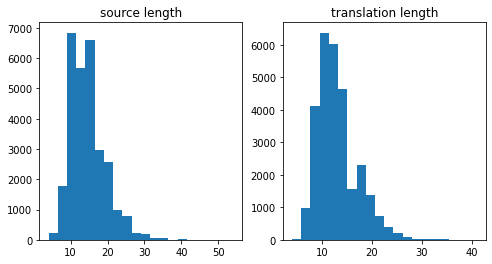

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


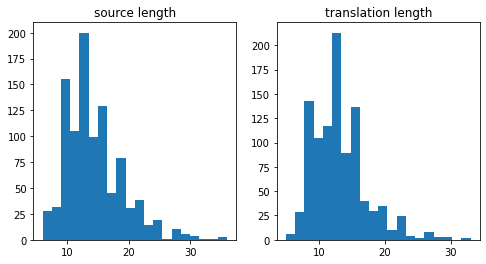

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
BATCH_SIZE = 222
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ATTENTION_DIM = 4
HID_DIM = 512
N_LAYERS = 4
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# https://www.youtube.com/watch?v=0OMgS3wNoog&list=RDI_wnoAn4UO8&index=12

In [ ]:
def _len_sort_key(x):
    return len(x.src)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                                        batch_size = BATCH_SIZE, 
                                                                        device = DEVICE,
                                                                        sort_key=_len_sort_key
)

In [ ]:
import my_network as proff

Encoder = proff.Encoder
Decoder = proff.Decoder
Seq2Seq = proff.Seq2Seq

In [ ]:
enc = Encoder(INPUT_DIM,  ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model_main = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

In [ ]:
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model_main.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6462, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=4, dropout=0.5)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_main):,} trainable parameters')

The model has 21,947,397 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']  #Write <pad> where key not present in TRG
optimizer = optim.ASGD(model_main.parameters(),
                          lr = 2*10-3)
loss_function = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    print('... Training')
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    print('... Testing')
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

# https://www.youtube.com/watch?v=I_wnoAn4UO8&list=RDI_wnoAn4UO8&start_radio=1
# https://www.youtube.com/watch?v=oM2TKqKlORU&list=RDI_wnoAn4UO8&index=4

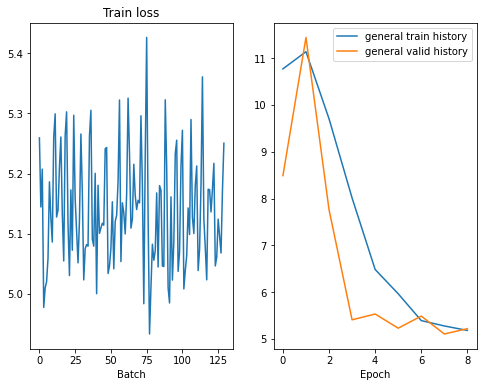

... Testing
Epoch: 10 | Time: 0m 41s
	Train Loss: 5.140 | Train PPL: 170.633
	 Val. Loss: 5.012 |  Val. PPL: 150.273


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_main, train_iterator, optimizer, loss_function, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_main, valid_iterator, loss_function)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_main.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [ ]:
import utils
import imp

imp.reload(utils)

generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens

get_text = utils.get_text
flatten = utils.flatten

Take a look at the example translation:

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_main, TRG.vocab)

Original: an older man is opening his arms wide and looking .
Generated: a man in a a a a a

Original: a man is working a hotdog stand .
Generated: a man in a a a a a



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text_proff = []
generated_text_proff = []

model_main.eval()

with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        prediction = model_main(src, trg, 0) #turn off teacher forcing
        prediction = prediction.argmax(dim=-1)
        
        original_text_proff.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text_proff.extend([get_text(x, TRG.vocab) for x in prediction[1:].detach().cpu().numpy().T])

5it [00:00, 13.36it/s]


In [ ]:
corpus_bleu([[text] for text in original_text_proff], generated_text_proff) * 100

2.1383247529275486

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set.

Here are some thresholds you might refer to (they may vary for different language pairs, but are good references for pairs line EN-FR or EN-GE):

* __18__ – good starting point

* __20__ – better

* __25__ – excellent score



---



---



In [ ]:
import attention_network as attention_ntwrk

Encoder = attention_ntwrk.Encoder
Decoder = attention_ntwrk.Decoder
Attention = attention_ntwrk.Attention
Seq2Seq = attention_ntwrk.Seq2Seq

In [ ]:
enc = Encoder(INPUT_DIM,  ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
attention = Attention(HID_DIM, ATTENTION_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model_attention  = Seq2Seq(enc, dec, DEVICE). to(DEVICE)
optimizer = optim.Adam(model_attention.parameters())

In [ ]:
model_attention.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6462, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=4, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
print(f'The model has {count_parameters(model_attention):,} trainable parameters')

The model has 19,381,001 trainable parameters


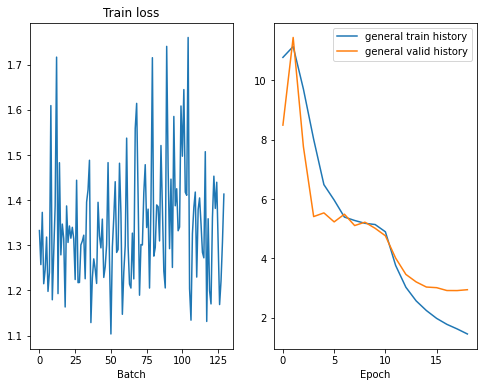

... Testing
Epoch: 10 | Time: 0m 42s
	Train Loss: 1.343 | Train PPL:   3.829
	 Val. Loss: 2.994 |  Val. PPL:  19.962


In [ ]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_attention, train_iterator, optimizer, loss_function, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_attention, valid_iterator, loss_function)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attention.state_dict(), 'attention-model_1.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: an older man is opening his arms wide and looking .
Generated: an older man is holding his right and and looks like be be looking

Original: a man is working a hotdog stand .
Generated: a man is working on a hotdog . .



In [ ]:
original_text = []
generated_text = []

model_attention.eval()

with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        prediction = model_attention(src, trg, 0) #turn off teacher forcing
        prediction = prediction.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in prediction[1:].detach().cpu().numpy().T])

5it [00:00, 13.53it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

40.561276619378276



---



---



In [ ]:
text_train= [' '.join(train_data.examples[i].src[::-1]) for i in range(len(train_data.examples))]
text_test = [' '.join(test_data.examples[i].src[::-1]) for i in range(len(test_data.examples))]
y_train =   [' '.join(train_data.examples[i].trg) for i in range(len(train_data.examples))]
y_test =    [' '.join(test_data.examples[i].trg) for i in range(len(test_data.examples))]

In [ ]:
text_train[0], y_train[0]

('deux jeunes hommes blancs sont dehors près de buissons .',
 'two young , white males are outside near many bushes .')

In [ ]:
SRC.vocab.itos

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'un',
 '.',
 'une',
 'de',
 'en',
 "d'",
 'dans',
 'sur',
 'homme',
 'et',
 'des',
 'avec',
 'la',
 'à',
 ',',
 'femme',
 "l'",
 'deux',
 'le',
 'est',
 '-',
 'debout',
 'se',
 'personnes',
 'sont',
 'jeune',
 'au',
 'tandis',
 'devant',
 'hommes',
 'fille',
 'du',
 'groupe',
 'les',
 'garçon',
 'assis',
 'chien',
 'son',
 'rue',
 'rouge',
 "qu'",
 'noir',
 'portant',
 't',
 'shirt',
 'blanc',
 'pour',
 'gens',
 'trois',
 'train',
 'bleu',
 'eau',
 'femmes',
 'fait',
 'enfant',
 'enfants',
 'qui',
 'sa',
 'côté',
 'tient',
 'par',
 'autre',
 'regarde',
 'que',
 'petit',
 'joue',
 'près',
 "s'",
 'personne',
 'tenant',
 'vêtu',
 'jouant',
 'photo',
 'il',
 'jaune',
 'chemise',
 'air',
 'jeunes',
 'vélo',
 'jouent',
 'petite',
 'lors',
 'regardant',
 'a',
 'dehors',
 'bâtiment',
 'marche',
 'blanche',
 'lunettes',
 'veste',
 'ses',
 'assise',
 'trottoir',
 'dessus',
 'faisant',
 'saute',
 'regardent',
 'cheveux',
 'tout',
 'foule',
 'marchant',
 '

In [ ]:
vars(next(iter(train_iterator))).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'src', 'trg'])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
 
class RNNModel(nn.Module):
    def __init__(self, ntoken, ninp,
                 nhid, nlayers, bsz,
                 dropout=0.5, tie_weights=True):
        super(RNNModel, self).__init__()
        self.nhid, self.nlayers, self.bsz = nhid, nlayers, bsz
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)
        self.init_weights()
        self.hidden = self.init_hidden(bsz) # the input is a batched consecutive corpus
                                            # therefore, we retain the hidden state across batches
 
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.fill_(0)
        self.decoder.weight.data.uniform_(-initrange, initrange)
 
    def forward(self, input):
        emb = self.drop(self.encoder(input))
        output, self.hidden = self.rnn(emb, self.hidden)
        output = self.drop(output)
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))
 
    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (V(weight.new(self.nlayers, bsz, self.nhid).zero_().cuda()),
                V(weight.new(self.nlayers, bsz, self.nhid).zero_()).cuda())
  
    def reset_history(self):
        self.hidden = tuple(V(v.data) for v in self.hidden)

In [ ]:
weight_matrix = SRC.vocab.vectors

model_rnn = RNNModel(weight_matrix.size(0), weight_matrix.size(1), 200, 1, BATCH_SIZE)

model_rnn.encoder.weight.data.copy_(weight_matrix)

model_rnn.to(DEVICE)

AttributeError: ignored

In [ ]:
print(f'The model has {count_parameters(model_transformer):,} trainable parameters')

The model has 4,583,486 trainable parameters


TypeError: ignored

In [ ]:
y_train[0],text_train[0]